# Train different machine learning models on elastic properties of composites
After generation data on the anisotropic elastic behavior of composite materials with different geometric arrangements of the filler phase, different machine learning methods are trained to predict the properties as a function of the volume fraction and the geometric arrangement of the filler phase.

This Jupyter notebook uses ipywidgets for user interactions, the matplotlib (https://matplotlib.org/) library for the visualization of results, and NumPy (http://www.numpy.org) for mathematical operations with arrays, and the scikit-learn (https://scikit-learn.org/stable/) toolbox for machine learning.

Author: Alexander Hartmaier, ICAMS / Ruhr-Universität Bochum, Germany

July 2025

This work is licensed under a Creative 
Commons Attribution-NonCommercial-ShareAlike 4.0 International License
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">(CC-BY-NC-SA)</a>
 <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
<img alt="Creative Commons License" style="border-width:0;max-heigt:9px;height:100%;" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a>

The pyLabFEA package comes with ABSOLUTELY NO WARRANTY. This is free
software, and you are welcome to redistribute it under the conditions of
the GNU General Public License <a href="http://www.fsf.org/licensing/licenses/gpl.html">(GPLv3)</a> 

### Read libraries and define global objects

In [1]:
import os
import sys
import numpy as np
from sklearn import ensemble, tree
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# get absolute path to paket with class and widget definitions
package_path = os.path.abspath('../libs')
if package_path not in sys.path:
    sys.path.insert(0, package_path)

from ml_lib import ResultDB, extract_data, plot_comp


The scikit-learn intel acceleration is not installed on your system


### 1. Read data for training and testing
In this step, pre-defined data sets for training and testing of different mmachine learning models are imported. Change the file names if you want to use the data you generated in the previous tutorial.

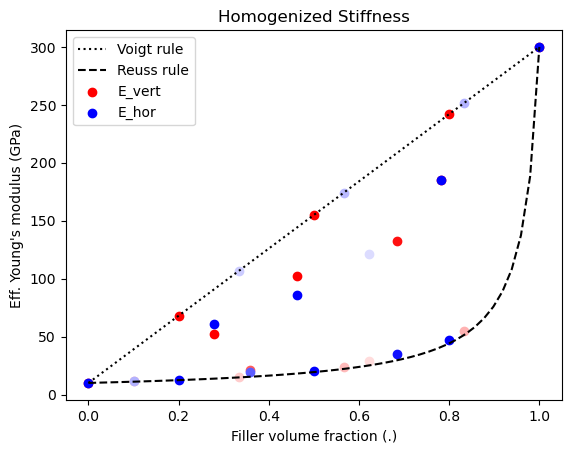

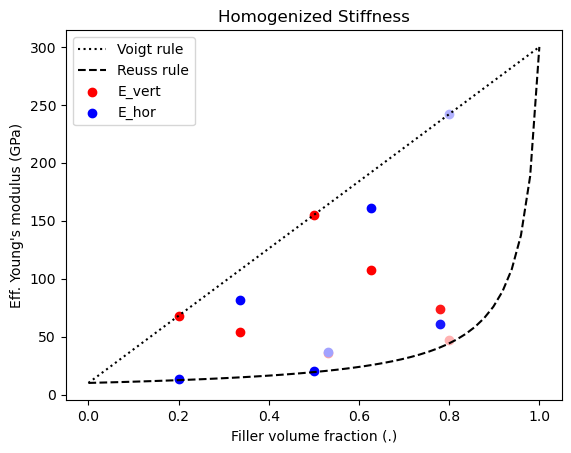

In [2]:
train = ResultDB(E1=10.0, E2=300.0)
train.read('training_data_10_300.json', path='../data')
fig = train.plot()

test = ResultDB(E1=10.0, E2=300.0)
test.read('test_data_10_300.json', path='../data')
fig = test.plot()


Preprocess data into features and labels than can be used for training and testing of different machine learning models.

In [3]:
# extract feature and labels from data
n_feat = 5
n_label = 2
x_train, y_train = extract_data(train, n_feat=n_feat, n_label=n_label)
x_test, y_test = extract_data(test, n_feat=n_feat, n_label=n_label)

# scale feature and label vectors for SVR and MLP
scaler_f = StandardScaler()  # scaler for feature vector
scaler_f.fit(x_train)  # set scaling parameters for training data
scaler_l = StandardScaler()  # scaler for label vector
scaler_l.fit(y_train)  # set scaling parameters for training labels

xt_scaled = scaler_f.transform(x_train)
yt_scaled = scaler_l.transform(y_train)
xtest_scaled = scaler_f.transform(x_test)
ytest_scaled = scaler_l.transform(y_test)

### 2. Random Forest regression
In the first step, a random forest regression model is trained.

Random Forest Regression
Training:  Mean Relative Error = 45.69%,  STD = 23.72
Test data: Mean Relative Error = 74.63%,  STD = 54.20


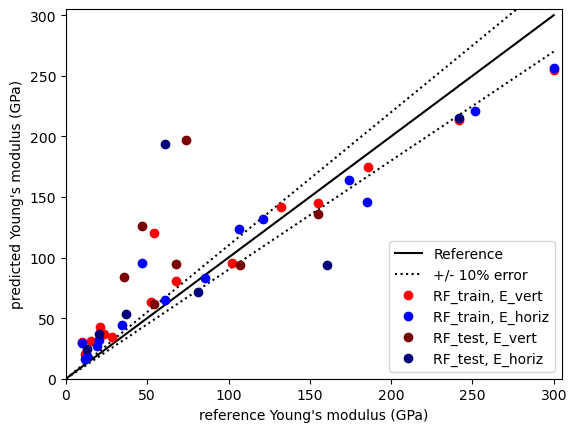

In [4]:
# Random forest regression
# works for unscaled data
Nest = 50
regr_rf = RandomForestRegressor(n_estimators=Nest, max_depth=10, random_state=2)
regr_rf.fit(x_train, y_train)

y_rf = regr_rf.predict(x_train)
ytest_rf = regr_rf.predict(x_test)
E_max = max(max(y_train.ravel()), max(y_rf.ravel()))

# Calculate scores
print('Random Forest Regression')
mre_rf = np.mean(np.abs(y_rf/y_train - 1))
std_rf = np.std(y_rf - y_train)
mre_rf_test = np.mean(np.abs(ytest_rf/y_test - 1))
std_rf_test = np.std(ytest_rf - y_test)
print(f'Training:  Mean Relative Error = {mre_rf*100:5.2f}%,  STD = {std_rf:5.2f}')
print(f'Test data: Mean Relative Error = {mre_rf_test*100:5.2f}%,  STD = {std_rf_test:5.2f}')

"""print('\nNumber of estimators (decision trees):')
print(Nest,'\n')
print('depth and number of leaves for first 5 decision trees after training:')
for dt in regr_rf.estimators_[0:np.minimum(5, Nest)]:
    print(dt.get_depth(), dt.get_n_leaves())"""

# Plot results
fig = plot_comp(y_pred=y_rf, y_ref=y_train, Emax=E_max, desc='RF', ytest_pred=ytest_rf, ytest_ref=y_test)

### 3. Support Vector Regression
Training and testing of a support vector regression model

Support Vector Regression
Training:  Mean Relative Error = 27.88%,  STD =  8.48
Test data: Mean Relative Error = 76.70%,  STD = 52.83


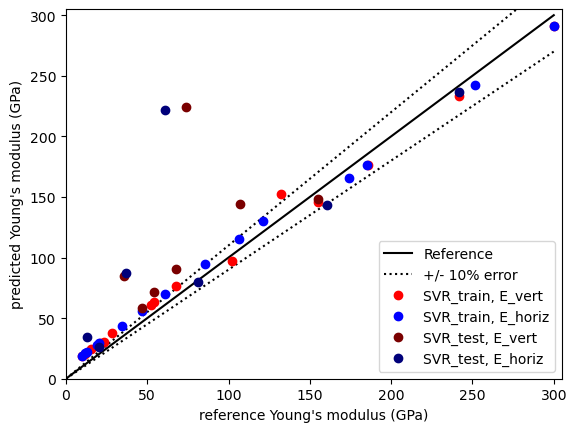

In [5]:
# Support Vector Regression
# requires scaled features and labels
# for each label (E_vert, E_hor) a separate SVR needs to be trained and evaluated
svr0 = SVR(kernel='rbf', C=4., gamma=0.5)
svr0.fit(xt_scaled, yt_scaled[:, 0])
svr1 = SVR(kernel='rbf', C=4., gamma=0.5)
svr1.fit(xt_scaled, yt_scaled[:, 1])

# evaluate trained model for training and test data
y_svr = np.array([svr0.predict(xt_scaled), svr1.predict(xt_scaled)]).T  # combine results to label array again
ytest_svr = np.array([svr0.predict(xtest_scaled), svr1.predict(xtest_scaled)]).T

y_svr = scaler_l.inverse_transform(y_svr)
ytest_svr = scaler_l.inverse_transform(ytest_svr)

E_max = max(max(y_train.ravel()), max(y_svr.ravel()))

# Calculate scores
mre_svr = np.mean(np.abs(y_svr/y_train - 1))
std_svr = np.std(y_svr - y_train)
mre_svr_test = np.mean(np.abs(ytest_svr/y_test - 1))
std_svr_test = np.std(ytest_svr - y_test)
print('Support Vector Regression')
print(f'Training:  Mean Relative Error = {mre_svr*100:5.2f}%,  STD = {std_svr:5.2f}')
print(f'Test data: Mean Relative Error = {mre_svr_test*100:5.2f}%,  STD = {std_svr_test:5.2f}')

# Look at the results
fig = plot_comp(y_pred=y_svr, y_ref=y_train, Emax=E_max, desc='SVR', ytest_pred=ytest_svr, ytest_ref=y_test)


### 4. Muli-layer Perceptron
In the last step, a multi-layer perceptron (MLP) or artificial neural network (ANN) is trained and tested.

Artificial Neural Networks
Training:  Mean Relative Error =  7.24%,  STD =  8.72
Test data: Mean Relative Error = 50.52%,  STD = 54.08


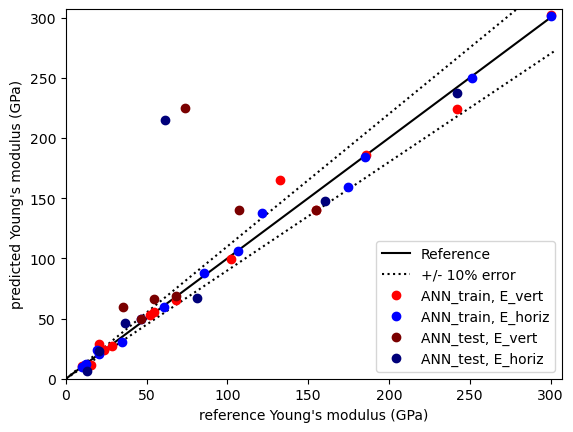

In [6]:
# Neural Network
# requires scaled features and labels
hid_layers = [80, 50, 60]
regr_ann = MLPRegressor(hidden_layer_sizes=hid_layers, random_state=1, max_iter=500)
regr_ann.fit(xt_scaled, yt_scaled)
y_ann = scaler_l.inverse_transform(regr_ann.predict(xt_scaled))
ytest_ann = scaler_l.inverse_transform(regr_ann.predict(xtest_scaled))

E_max = max(max(y_train.ravel()), max(y_ann.ravel()))

# Calculate scores
mre_ann = np.mean(np.abs(y_ann/y_train - 1))
std_ann = np.std(y_ann - y_train)
mre_ann_test = np.mean(np.abs(ytest_ann/y_test - 1))
std_ann_test = np.std(ytest_ann - y_test)
print('Artificial Neural Networks')
print(f'Training:  Mean Relative Error = {mre_ann*100:5.2f}%,  STD = {std_ann:5.2f}')
print(f'Test data: Mean Relative Error = {mre_ann_test*100:5.2f}%,  STD = {std_ann_test:5.2f}')

# Look at the results
fig = plot_comp(y_pred=y_ann, y_ref=y_train, Emax=E_max, desc='ANN', ytest_pred=ytest_ann, ytest_ref=y_test)

### 5. Property prediction
In this step, the trained ANN model is used to predict the elastic properties of an unknown composite material. Please use the notebook "composites" to generate a new composite material and to calculate its elastic properties and save the results as a JSON file.

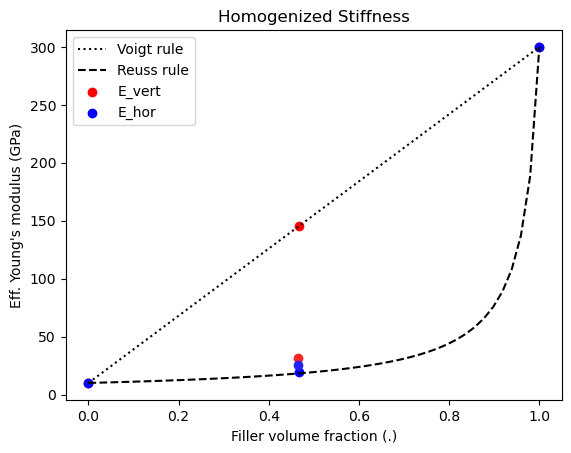

Predicted values:
 [[ 10.48810039   9.85555592]
 [302.0511988  301.40932605]
 [136.23098491  27.12379271]
 [ 69.72296682  64.59151933]]
Real values:
 [[ 10.          10.        ]
 [300.         300.        ]
 [145.33333333  19.10672338]
 [ 31.41297279  25.5398908 ]]
Rel. error (%):
 [[  4.88100388   1.44444082]
 [  0.68373293   0.46977535]
 [  6.26308378  41.95941489]
 [121.95596475 152.90444594]]


In [7]:
# extract volume fraction and shape parameters for unknown composite material
val = ResultDB(E1=10.0, E2=300.0)
val.read('results_10_300.json', path='../data')
fig = val.plot()

x_val, y_val = extract_data(val, n_feat=n_feat, n_label=n_label)
xv_scaled = scaler_f.transform(x_val)
y_pred = scaler_l.inverse_transform(regr_ann.predict(xv_scaled))
print('Predicted values:\n', y_pred)
print('Real values:\n', y_val)
print('Rel. error (%):\n', abs(y_pred/y_val - 1) * 100)